In [10]:
import subprocess
import os
import gudhi
import numpy as np
import wget

from pydub import AudioSegment
from csaps import csaps
from subprocess import Popen, PIPE
from numpy import genfromtxt
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Before we were able to plot smoothed PSD surfaces from dictionary words

In [83]:
def psd_smoother(word, wordWavPath, psdPath, matlabScriptsPath): #creates the smooth psd using matlab functions.
    matlabLocation = "/Applications/MATLAB_R2018b.app/bin" #the path for matlab 
    
    myBashCommands = ["cd " + matlabLocation + ";"] #go inside matlab package
    myBashCommands[0] += "./matlab -nodesktop -r " #run with no desktop
    myBashCommands[0] += "'cd(\"" + matlabScriptsPath + "\"); "  #cd to our directory containing our matlab scripts
    myBashCommands[0] += "word_wav = audioread(\""+ wordWavPath + "\"); " #read in our word
    myBashCommands[0] += "[f, t,  psd] = GetSpectrogram(word_wav, 16000, 10); " #compute spectrogram
    myBashCommands[0] += "smooth_psd = smoothn(10*log(psd), .5); " #smooth it 
    myBashCommands[0] += "smooth_psd = SurfaceCubicInterpolator(smooth_psd, 100); " #smooth it again
    myBashCommands[0] += "dlmwrite(\"" + psdPath + word + "_smooth_psd.csv\", smooth_psd, char(\"precision\"), 10);" #save psd data
    myBashCommands[0] += "quit()'" #close matlab

    subprocess.run(myBashCommands,stderr=PIPE, stdout=PIPE, shell = True, check = True) #run all of our above bash commands


In [142]:
#Path containing this notebook; change this!
myPath = '/Users/luketrujillo/Desktop/Senior_year/Spring/Seminar_in_Diff_Geo/143_final_project/code/' 

def word_to_surface(word, myPath, accent='us'): #given a word, download the .mp3 from oxford and return the signal and frequency.
    myPath = '/Users/luketrujillo/Desktop/Senior_year/Spring/Seminar_in_Diff_Geo/143_final_project/code/' 
    
    ## Setting paths for later; keeps things organized.
    wavPath = myPath + "wavs/"                      #full path for the the .wav files
    psdPath = myPath + "psd_data/"                  #full path for the psd data 
    matlabScriptsPath = myPath + "matlab_scripts/"  #full path to get to the matlab scripts
    
    ## Now we get the words from the web and compute the psd
    url = 'https://ssl.gstatic.com/dictionary/static/sounds/oxford/{}--_{}_1.mp3'.format(word, accent) #warning: the oxford website could change their website formats for .mp3s in the future; may be a bug source in the future
    wavFileName = wavPath + '{}-{}'.format(word, accent)
    
    print(wavFileName)
    if not os.path.isfile(wavFileName + '.wav'):            #if we haven't made the .wav before, then make it
        wget.download(url, wavFileName + '.mp3')            #download the .mp3
        sound = AudioSegment.from_mp3(wavFileName + '.mp3') 
        sound.export(wavFileName + '.wav', format="wav")    #the .wav is now created. 
    
    psdCSV = psdPath + word + "_smooth_psd.csv" #our psd data
    if not os.path.isfile(psdCSV):              #if we haven't made the .csv before, then make it
        wordWavPath = wavFileName + ".wav"
        psd_smoother(word, wordWavPath, psdPath, matlabScriptsPath,) #call helper function to compute psd
    
    word_psd = genfromtxt(psdCSV, delimiter=',')
    
    print(word_psd.shape)
    ## finally, we plot the surface
    xdata = [np.linspace(0, 81, 81), np.linspace(0, 100, 100)] #our x-y coordinates
    i,j = np.meshgrid(*xdata, indexing = "ij")              #creates the 81x100 grid
#     zdata_s = word_psd
    zdata_s = csaps(xdata, word_psd, xdata, smooth=0.3)   #using csaps to smooth our surface
    
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_facecolor('none')
    c = [s['color'] for s in plt.rcParams['axes.prop_cycle']]
    ax.scatter(j, i, zdata_s, linewidths=0.5, color=c[0], alpha=0.5)
    ax.plot_surface(j, i, zdata_s, color=c[1], linewidth=0, alpha=1)
    ax.view_init(elev=25, azim=40)
    
    plt.title("\'" + word + "\'" + " PSD surface")
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency ')
    ax.set_zlabel('PSD')

    plt.show()
    
    return zdata_s

## Next, we apply persistence homology in our analysis.

In [194]:
def surface_coordinates(z_data, lowerbd): #nonzero surface data
    X = [] #initialize our coordinates
    Y = []
    Z = []
    for j in range(0, 81):
        for k in range(0, 100):
            if z_data[j][k] > lowerbd:
                X.append(j)
                Y.append(k)
                Z.append(z_data[j][k])
    return X, Y, Z

def surface_pers_diag(X,Y,Z, plotPers = False):
    points = []
    for i in range(0, len(X)):
        points.append([ X[i], Y[i], Z[i] ])                                    #Creates a list of triples of 3D points 
    rips = gudhi.RipsComplex(points, max_edge_length=42)                       #Creates ripser complex
    simplex_tree = rips.create_simplex_tree(max_dimension=2)                   #creates simplices
    diag = simplex_tree.persistence(homology_coeff_field=2, min_persistence=0) #computes persistence diagram
    
    if plotPers:
        gudhi.plot_persistence_diagram(diag) #plots the points
        plt.show()                          #graphs the points
    return diag


#We put together our previous two functions to create a general one which plots the surface and the persistence diagram.

def plot_and_pers_diagram(matrix, lowerbd, timeScale, show3Dplot = False, plotPers = False): #the lowerbd is the minimum grayscale value which we'll care about
    if show3Dplot:                  #Set plotme = True if you want to see the 3D representation of the surface.
        Xs = np.linspace(0, 81, 81) #initialize our coordinates
        Ys = np.linspace(0, 100, 100)
        xdata = [Xs, Ys] #our x-y coordinates
        i,j = np.meshgrid(*xdata, indexing = "ij")  #creates the 28x28 grid

        fig = plt.figure(figsize=(15, 10)) #creates a large plotting area
        ax = plt.axes(projection='3d')     #creates axes                               

        cm = plt.get_cmap("rainbow")       #color theme is "rainbow"; can change e.g. "spring", "gist_gray", "hsv"                          
        col = []                           #we want color to vary by height. So we create different colors for each point.
        for m in range(81):                #iterating through all of our points,
            for n in range(100):
                col.append( cm(float(matrix[m][n])/255)) #we set the color for each point by normalizing by max height 255.
        ax.scatter(i, j, matrix, c=col) #plots the surface
        ax.set_xlabel('Frequency')
        ax.set_ylabel('Time ')
        ax.set_zlabel('PSD')
        ax.view_init(elev=25, azim=40)
    
    X,Y,Z = surface_coordinates(matrix, lowerbd)        #creates the coordinates of the surface
    diag = surface_pers_diag(Y,X,Z, plotPers)           #plots the persistence diagram of the surface
    return diag

/Users/luketrujillo/Desktop/Senior_year/Spring/Seminar_in_Diff_Geo/143_final_project/code/wavs/no-us
(81, 100)


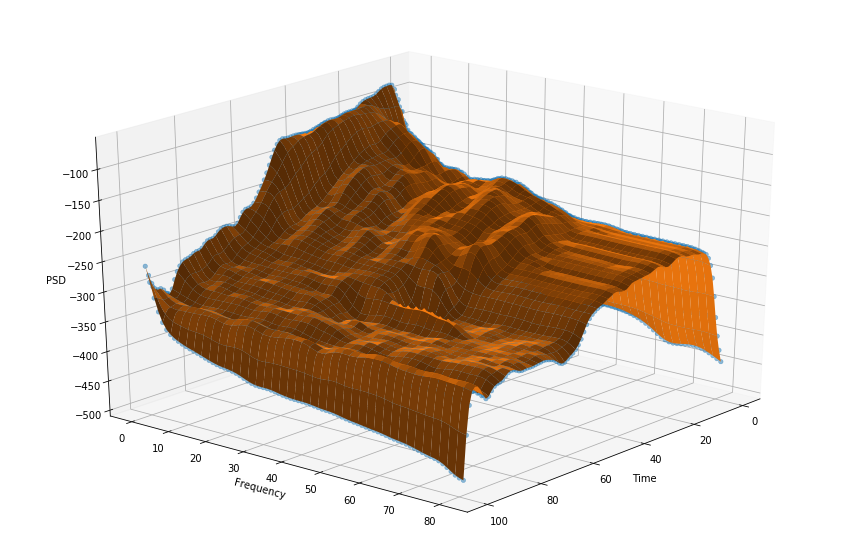

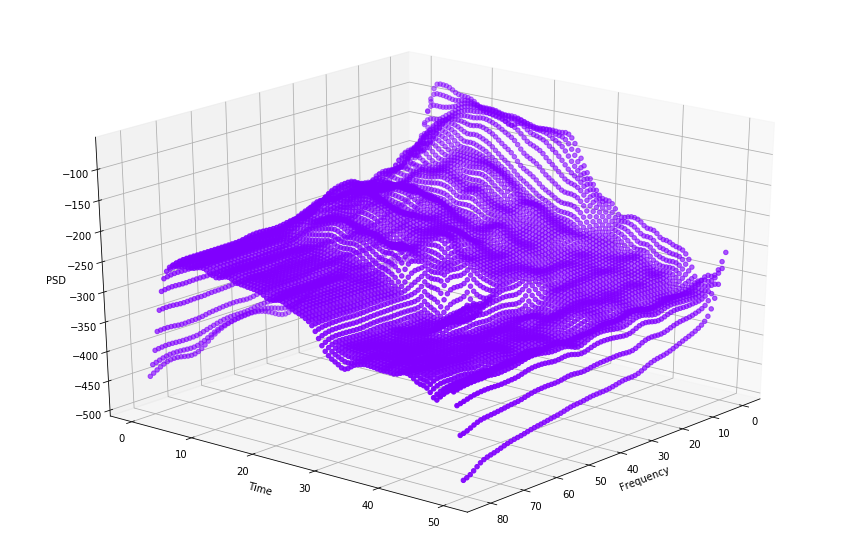

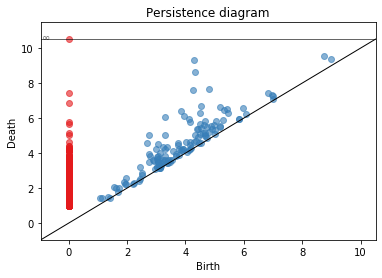

[(1, (4.306837917512288, 9.326097216624886)),
 (1, (4.315786677257882, 8.653691941414166)),
 (1, (4.274043451692867, 7.589728629668856)),
 (1, (4.820961653151218, 7.639150353072354)),
 (1, (3.302629669747603, 6.083900844106034)),
 (1, (3.856954150906866, 6.410884626200896)),
 (1, (2.7427142819432944, 5.014707575520921)),
 (1, (4.53677432196201, 6.709884752097277)),
 (1, (3.9622350678278337, 6.102391865393714)),
 (1, (2.687915145260301, 4.57072775743697)),
 (1, (4.123451725909042, 5.973535828795091)),
 (1, (4.497154747457742, 6.276132141174068)),
 (1, (3.284563226542052, 5.044332299164183)),
 (1, (4.146310287657101, 5.795793404346334)),
 (1, (3.0730866319407166, 4.53522451130895)),
 (1, (5.179117755188599, 6.615455655923282)),
 (1, (2.9965105492847743, 4.245943272897942)),
 (1, (2.741532348839352, 3.9293180722319923)),
 (1, (4.488320514957082, 5.641995459376457)),
 (1, (4.659151243827879, 5.805789457639084)),
 (1, (3.220703806233824, 4.363938124304524)),
 (1, (5.319862324487598, 6.44184

In [167]:
zdata_s = word_to_surface("no", myPath) #potato
plot_and_pers_diagram(zdata_s, -160, 0.5, True, True) 

/Users/luketrujillo/Desktop/Senior_year/Spring/Seminar_in_Diff_Geo/143_final_project/code/wavs/yes-us
(81, 100)


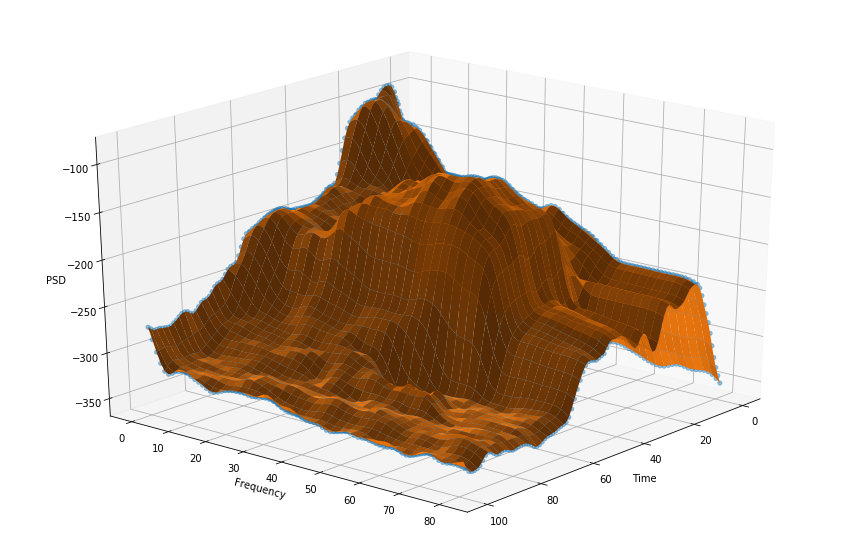

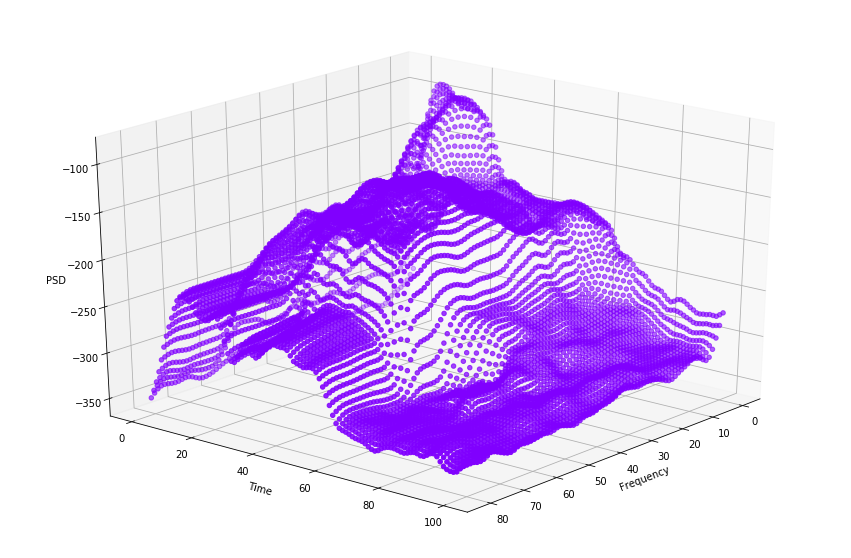

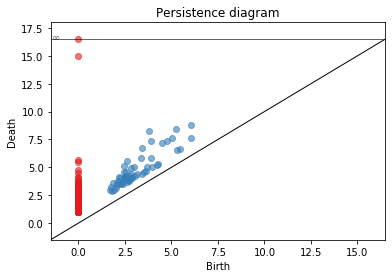

[(1, (3.767515960894615, 8.26404937956181)),
 (1, (3.8970844733497443, 7.403734244338395)),
 (1, (3.418166755166606, 6.742316472911738)),
 (1, (5.254735231786327, 8.422269377411206)),
 (1, (2.6297209856579538, 5.587107408578395)),
 (1, (6.071674311642158, 8.8079692591904)),
 (1, (4.491562955707553, 7.212263552104683)),
 (1, (2.454637989997426, 5.114087697164295)),
 (1, (5.011056597573059, 7.65996747196471)),
 (1, (4.744118148088293, 7.332906897198761)),
 (1, (3.353572582493239, 5.821510477091844)),
 (1, (2.423292500052755, 4.610230107208289)),
 (1, (2.8127935369003088, 4.931556204547798)),
 (1, (2.5551296546850546, 4.607134025195832)),
 (1, (2.963201034412314, 5.000708792119246)),
 (1, (3.880870603329204, 5.826719678462391)),
 (1, (2.177542532818015, 4.089215404822221)),
 (1, (2.241612439016015, 4.01310001173342)),
 (1, (1.874927359582826, 3.5974663518081873)),
 (1, (2.5188461494135566, 4.213162990369675)),
 (1, (2.105479360079496, 3.773224692630832)),
 (1, (2.829005026347766, 4.436865

In [202]:
zdata_s = word_to_surface("yes", myPath) #potato
plot_and_pers_diagram(zdata_s, -160, 0.5, True, True) 

/Users/luketrujillo/Desktop/Senior_year/Spring/Seminar_in_Diff_Geo/143_final_project/code/wavs/tarnation-us
(81, 100)


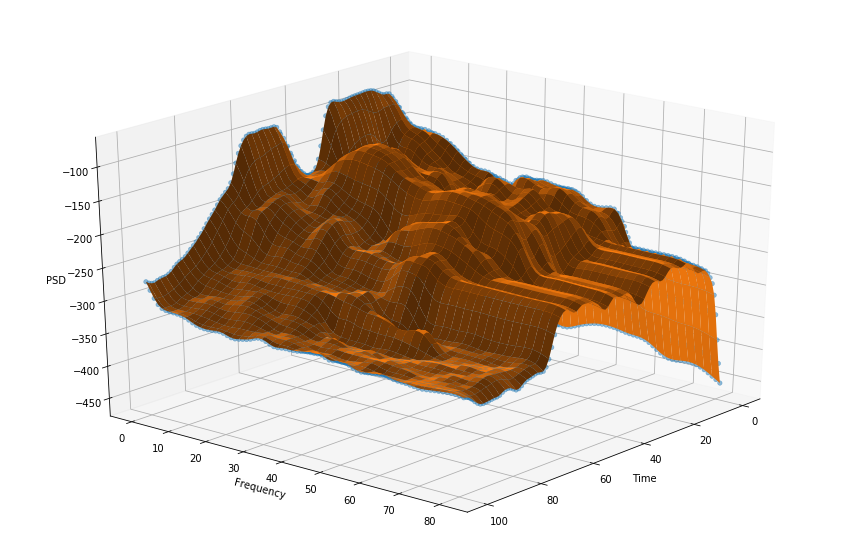

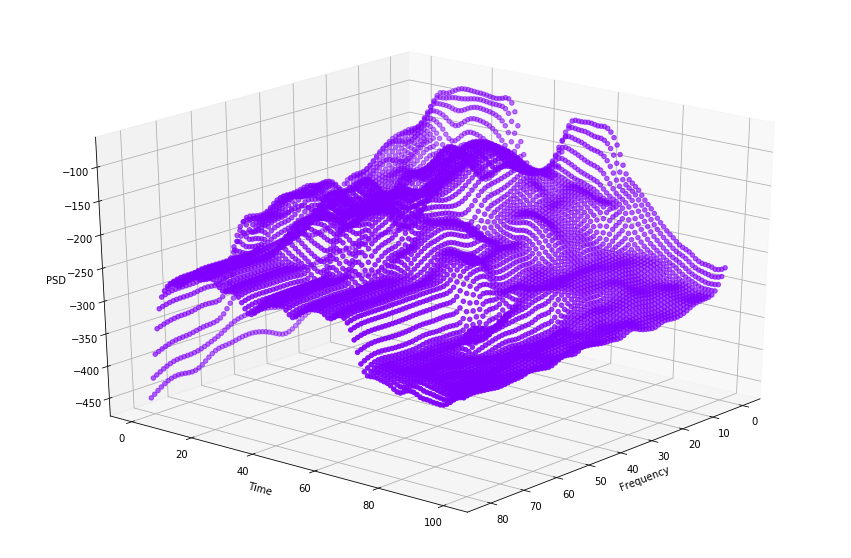

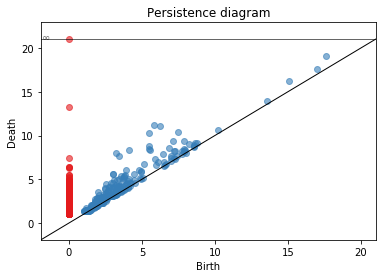

[(1, (5.805963314427129, 11.170916153278155)),
 (1, (6.229111785512559, 11.064957278548796)),
 (1, (3.1999447493459465, 8.023112303112429)),
 (1, (5.501471304697065, 10.234562587987124)),
 (1, (3.402542594836482, 7.695570241538917)),
 (1, (4.12599508865807, 8.372908357026002)),
 (1, (5.478267953373132, 8.769016805564114)),
 (1, (5.473210195492276, 8.466339898532024)),
 (1, (7.502960638016186, 10.409196066242131)),
 (1, (5.535919020072651, 8.320686507335488)),
 (1, (2.9901377638294386, 5.579434474616001)),
 (1, (3.0248232701260505, 5.551325149758232)),
 (1, (3.891083625004192, 6.107678539720879)),
 (1, (7.155664962921556, 9.327862245680619)),
 (1, (2.549369284312192, 4.516690955734777)),
 (1, (3.0999399413304576, 4.916807455431114)),
 (1, (3.577820609342831, 5.338040272696533)),
 (1, (6.866698797593437, 8.602411988500199)),
 (1, (2.852882197396752, 4.542935789684256)),
 (1, (3.8486540500470214, 5.521715169082617)),
 (1, (3.759033937067088, 5.396909496651336)),
 (1, (3.4346457059151048, 

In [203]:
zdata_s = word_to_surface("tarnation", myPath) #potato
plot_and_pers_diagram(zdata_s, -160, 0.5, True, True) 

/Users/luketrujillo/Desktop/Senior_year/Spring/Seminar_in_Diff_Geo/143_final_project/code/wavs/vacation-us
(81, 100)


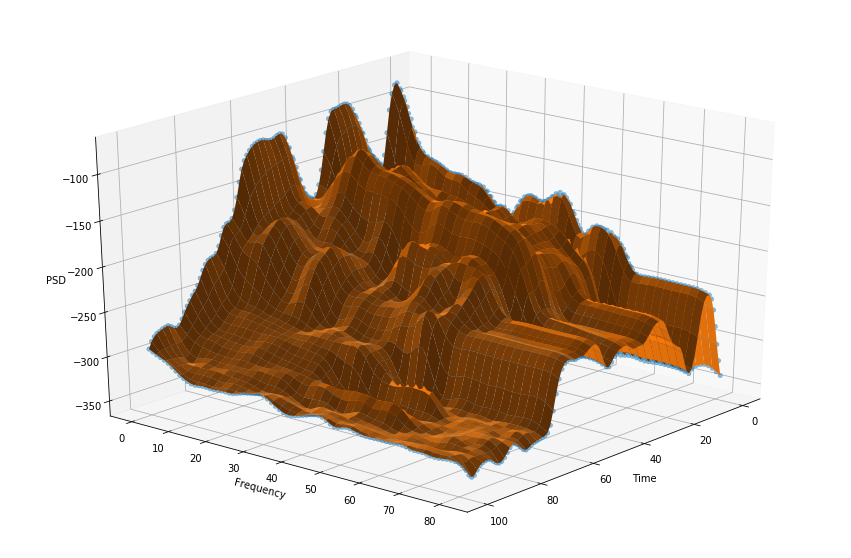

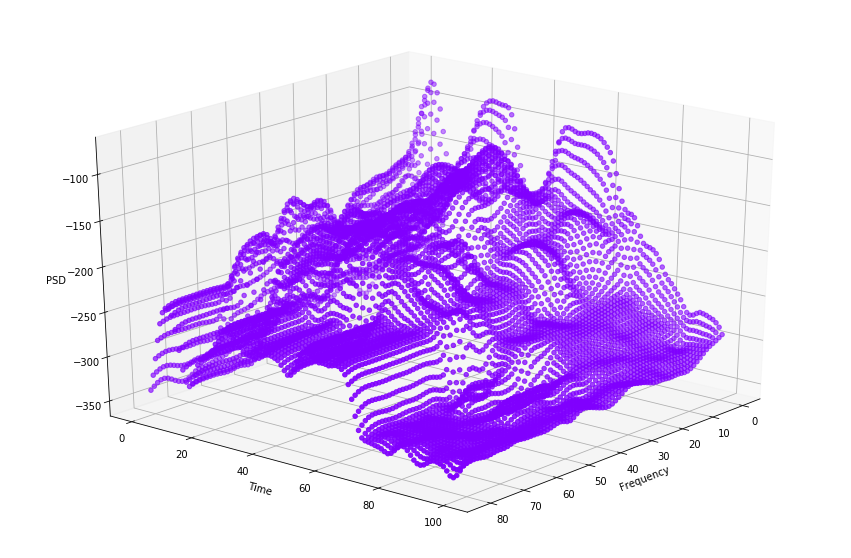

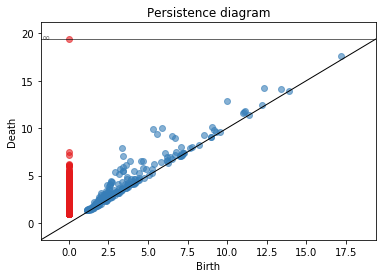

[(1, (5.301809511035318, 9.967383135984546)),
 (1, (3.3435975719402355, 7.947095461149612)),
 (1, (5.85743486195102, 10.018698761474122)),
 (1, (5.5409429857352395, 9.343089419976861)),
 (1, (3.4445237733069525, 7.108146592129209)),
 (1, (10.024362500629616, 12.910590510550568)),
 (1, (6.521256936600269, 9.168566131064528)),
 (1, (3.8489839601180424, 6.495934181998206)),
 (1, (3.5833331833737976, 6.090988943651861)),
 (1, (3.2081199621022027, 5.69431516072698)),
 (1, (3.428588329651273, 5.910097997392481)),
 (1, (2.9338808647564623, 5.376504079533256)),
 (1, (6.722523182287461, 8.947875348400913)),
 (1, (3.398659538340659, 5.528615148397672)),
 (1, (4.564066171053057, 6.593383711186617)),
 (1, (3.4477827309782327, 5.454861080762008)),
 (1, (3.17505553715659, 5.161408232823682)),
 (1, (12.322355292763886, 14.225909457137396)),
 (1, (4.666195154386646, 6.525821213354872)),
 (1, (2.6498049739416727, 4.469765482182178)),
 (1, (2.3984566172628097, 4.051585390172558)),
 (1, (2.67279982913087

In [204]:
zdata_s = word_to_surface("vacation", myPath) #potato
plot_and_pers_diagram(zdata_s, -160, 0.5, True, True) 

## Generalize to .wav Files

In [97]:
#Path containing this notebook; change this!
myPath = '/Users/luketrujillo/Desktop/Senior_year/Spring/Seminar_in_Diff_Geo/143_final_project/code/' 

def wav_to_surface(word, myPath, accent='us'): #given a word, download the .mp3 from oxford and return the signal and frequency.
    
    ## Setting paths for later; keeps things organized.
    m4aPath = myPath + "m4a_audios/"
    wavPath = myPath + "wavs/"                      #full path for the the .wav files
    psdPath = myPath + "psd_data/"                  #full path for the psd data 
    matlabScriptsPath = myPath + "matlab_scripts/"  #full path to get to the matlab scripts
    
    ## the location and name of our .wav; note we do not add .wav at the end here...
    wavFileName = wavPath + word
    
    psdCSV = psdPath + word + "_smooth_psd.csv" #our psd data
    if not os.path.isfile(psdCSV):              #if we haven't made the .csv before, then make it
        wordWavPath = wavFileName + ".wav"
        
        sound = AudioSegment.from_file(m4aPath + word + ".m4a")
        sound.export(wavFileName + ".wav", format="wav")
        sound = AudioSegment.from_wav(wavFileName + ".wav")
        sound = sound.set_channels(1)
        sound.export(wavFileName + ".wav", format="wav")
            
        psd_smoother(word, wordWavPath, psdPath, matlabScriptsPath,) #call helper function to compute psd
    
    word_psd = genfromtxt(psdCSV, delimiter=',')
    
    print(word_psd.shape)
    ## finally, we plot the surface
    xdata = [np.linspace(0, 81, 81), np.linspace(0, 100, 100)] #our x-y coordinates
    i,j = np.meshgrid(*xdata, indexing = "ij")              #creates the 81x100 grid
#     zdata_s = word_psd
    zdata_s = csaps(xdata, word_psd, xdata, smooth=0.3)   #using csaps to smooth our surface
    
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_facecolor('none')
    c = [s['color'] for s in plt.rcParams['axes.prop_cycle']]
    ax.scatter(j, i, zdata_s, linewidths=0.5, color=c[0], alpha=0.5)
    ax.plot_surface(j, i, zdata_s, color=c[1], linewidth=0, alpha=1)
    ax.view_init(elev=25, azim=40)
    
    plt.title("\'" + word + "\'" + " PSD surface")
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Time ')
    ax.set_zlabel('PSD')

    plt.show()
    
    return zdata_s

(81, 100)


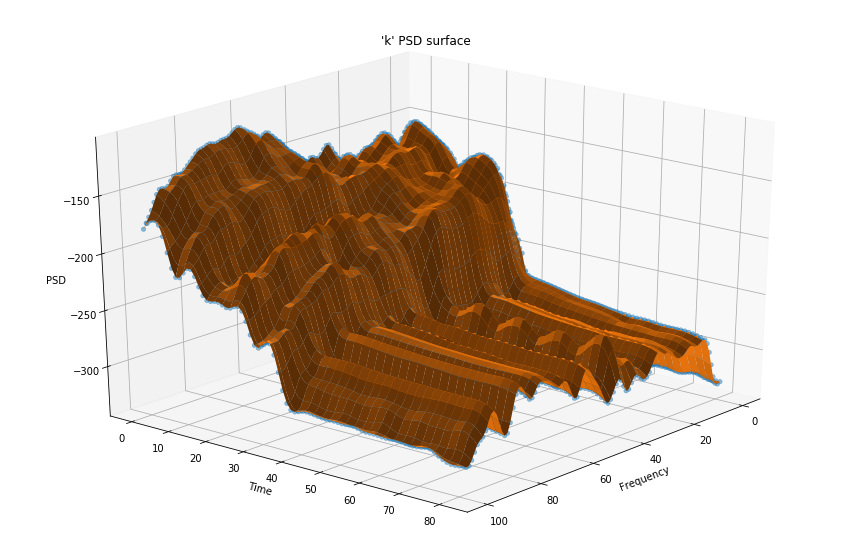

[(1, (3.5023038656402465, 6.3238429818068065)),
 (1, (6.1293182934109725, 8.764924795945912)),
 (1, (3.5057169847782825, 6.083490147490729)),
 (1, (3.3713023652043157, 5.438554899079019)),
 (1, (4.55824262356034, 6.555216433135333)),
 (1, (2.4933956258422088, 4.3107584484749815)),
 (1, (5.0811746421279524, 6.865310618894045)),
 (1, (2.3623892350073805, 3.94916125415798)),
 (1, (5.242923817575597, 6.765912399403904)),
 (1, (4.60652451501845, 6.1108806952581265)),
 (1, (4.748458368866572, 5.90723107503302)),
 (1, (5.704220926644908, 6.860743429155573)),
 (1, (2.4299228988409967, 3.4276412489255605)),
 (1, (5.156871568858025, 6.1169827426869015)),
 (1, (3.5781193857345492, 4.470327851844064)),
 (1, (5.871445794226419, 6.762482217085155)),
 (1, (2.5537009276054476, 3.20545759230905)),
 (1, (5.451474993412383, 6.089849607745276)),
 (1, (2.3165492430881884, 2.9537920265531583)),
 (1, (2.243947744556645, 2.8470647277213623)),
 (1, (4.449364572028227, 5.048179240903285)),
 (1, (2.5894953694609

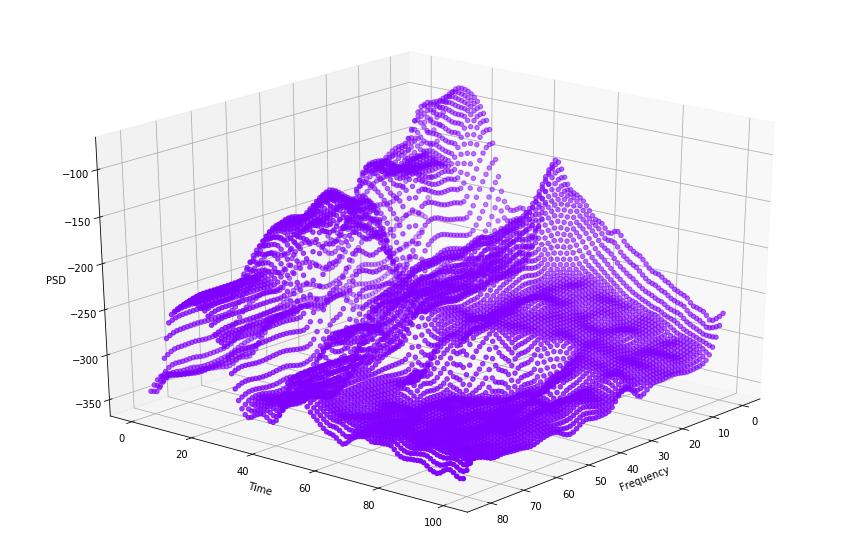

In [170]:
k_data_s = wav_to_surface("k", myPath)
plot_and_pers_diagram(zdata_s, -150, True, True) #k

(81, 100)


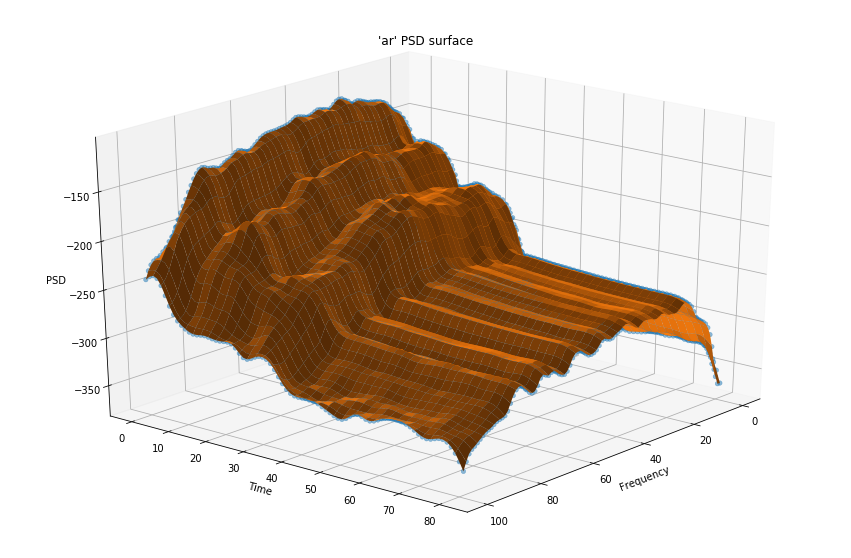

[(1, (3.445908621009401, 6.3238429818068065)),
 (1, (6.1293182934109725, 8.764924795945912)),
 (1, (3.5057169847782825, 6.083490147490729)),
 (1, (3.3713023652043157, 5.438554899079019)),
 (1, (4.55824262356034, 6.555216433135333)),
 (1, (2.7798922328199227, 4.774426654715064)),
 (1, (2.4933956258422088, 4.3107584484749815)),
 (1, (5.0811746421279524, 6.865310618894045)),
 (1, (2.3623892350073805, 3.94916125415798)),
 (1, (1.8693872501942987, 3.422696062817212)),
 (1, (3.113609911234672, 4.648031608075745)),
 (1, (5.242923817575597, 6.765912399403904)),
 (1, (4.60652451501845, 6.1108806952581265)),
 (1, (5.554333106351642, 7.039673711851722)),
 (1, (2.2588712349509694, 3.606338010437036)),
 (1, (3.0422697370236955, 4.300892631087124)),
 (1, (2.777675950270418, 4.005665220177374)),
 (1, (3.0827036061856297, 4.267322742144104)),
 (1, (4.748458368866572, 5.90723107503302)),
 (1, (5.704220926644908, 6.860743429155573)),
 (1, (1.6898200277373272, 2.722094928577725)),
 (1, (2.429922898840996

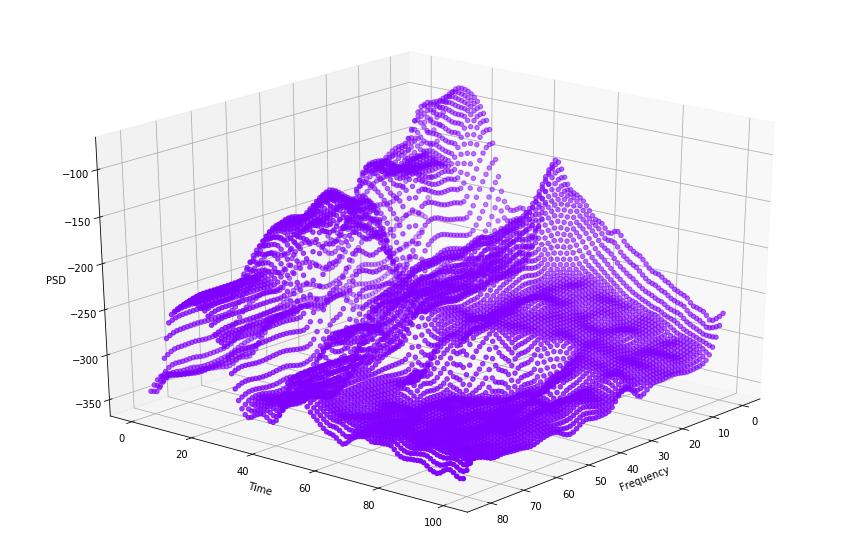

In [171]:
ar_data_s = wav_to_surface("ar", myPath)
plot_and_pers_diagram(zdata_s, -160, True, True) #ar

/Users/luketrujillo/Desktop/Senior_year/Spring/Seminar_in_Diff_Geo/143_final_project/code/wavs/car-us
(81, 100)


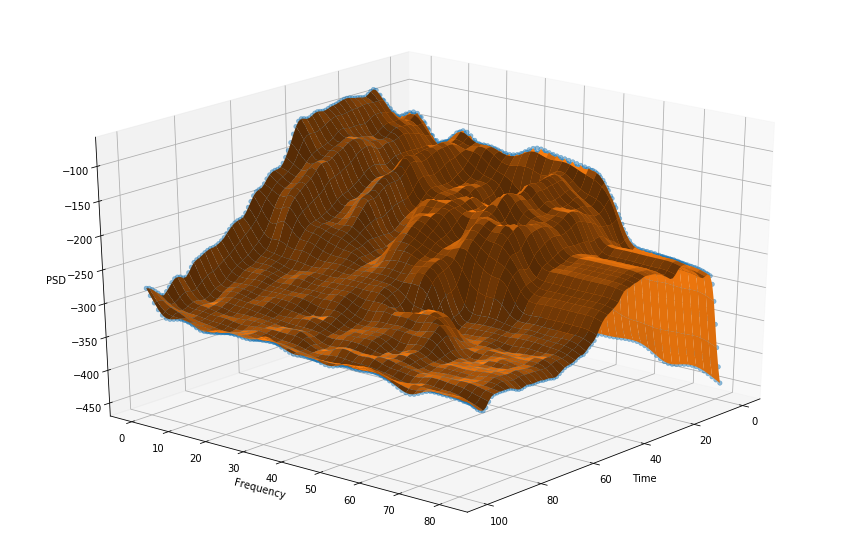

[(1, (3.3570203299203825, 7.743057137592131)),
 (1, (4.452916068860647, 8.506009133592611)),
 (1, (6.251487980128305, 9.993235039000309)),
 (1, (3.8748939800495137, 7.367140241202792)),
 (1, (2.82243771388113, 6.117485536694429)),
 (1, (4.188377433344207, 7.454200171865666)),
 (1, (4.023539617842959, 7.017243356756917)),
 (1, (3.1708359878691255, 5.969924783420886)),
 (1, (3.730261268642206, 6.502802642690639)),
 (1, (3.5370943092443348, 6.1596448882877235)),
 (1, (3.416629501551995, 5.91439181017001)),
 (1, (2.6066277372348905, 5.092375593285081)),
 (1, (5.248380691196825, 7.6722369318569905)),
 (1, (2.4979396077053946, 4.876384188872081)),
 (1, (2.7017282352787024, 4.98112718388333)),
 (1, (4.87543060632059, 7.126958067403585)),
 (1, (3.0037266824765365, 5.100876136474937)),
 (1, (2.275475906788048, 4.217246344271208)),
 (1, (2.401838598460231, 4.141098981003115)),
 (1, (2.68220318386123, 4.275752542499042)),
 (1, (5.777892982744337, 7.3515280083792645)),
 (1, (4.57533058664695, 6.12

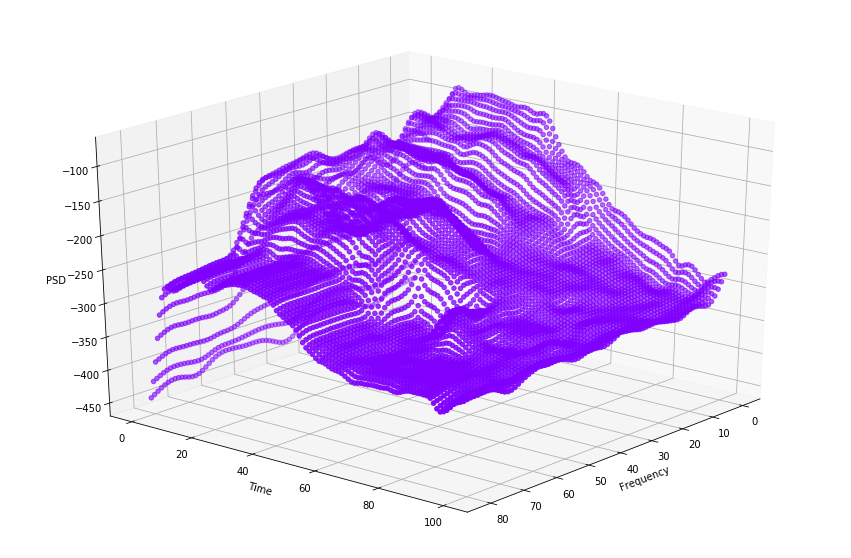

In [195]:
car_data_s = word_to_surface("car", myPath)
plot_and_pers_diagram(car_data_s, -160, True, True) #car

(81, 100)


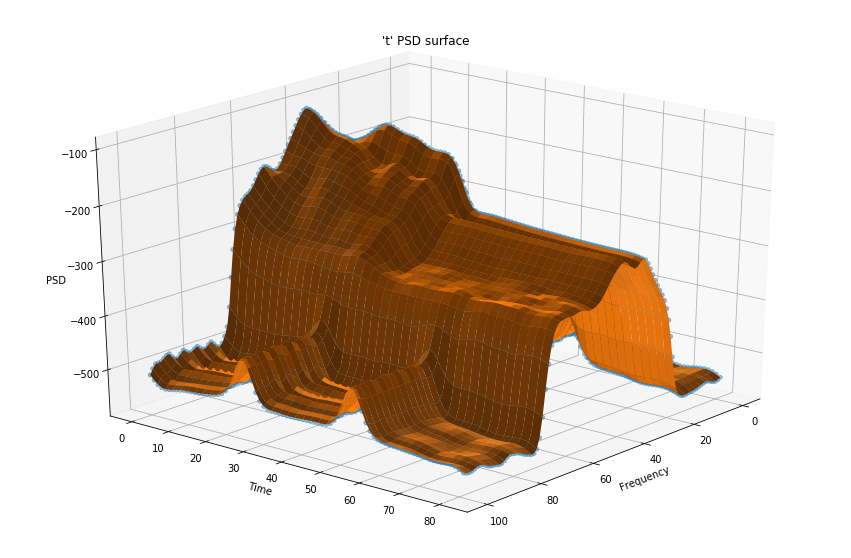

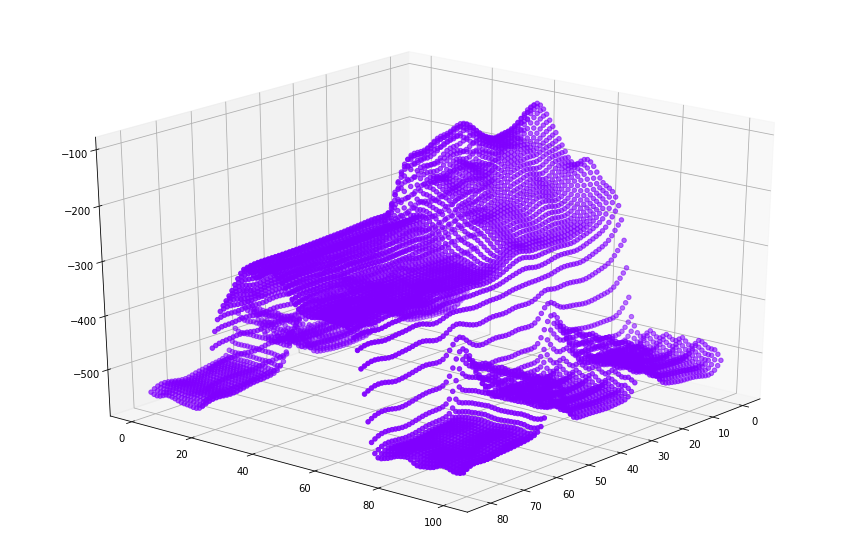

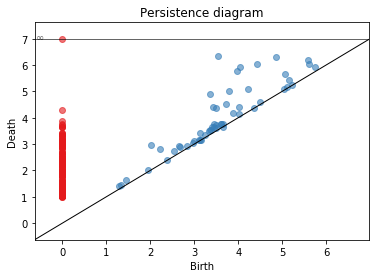

[(1, (3.5383882726994087, 6.349230601058093)),
 (1, (4.045514822301569, 5.934580046997966)),
 (1, (3.9663449657946717, 5.76017817858819)),
 (1, (4.428149728500036, 6.027544412904042)),
 (1, (3.3464016066292266, 4.883050184404018)),
 (1, (4.86149915879735, 6.285768367889865)),
 (1, (3.7845265856012986, 5.020971755907547)),
 (1, (3.419459503449058, 4.4106916836121455)),
 (1, (2.0096732723308564, 2.9639445136757168)),
 (1, (4.21978183063075, 5.1012246384220505)),
 (1, (3.4992051965231687, 4.360170620635527)),
 (1, (3.720974914457935, 4.526649481005568)),
 (1, (5.0567572097824, 5.6589496010000895)),
 (1, (5.58219592171203, 6.176904048954122)),
 (1, (2.2258906783617505, 2.810823169358999)),
 (1, (5.6036929419283865, 6.0546131119852085)),
 (1, (4.015818925525345, 4.420508249302693)),
 (1, (3.882846402390562, 4.184409323093079)),
 (1, (3.458647584137581, 3.7584165572013783)),
 (1, (5.1459451062272885, 5.439740025516159)),
 (1, (3.1189766625109017, 3.402743502199431)),
 (1, (2.6469062455019756

In [108]:
zdata_s = wav_to_surface("t", myPath)
plot_and_pers_diagram(zdata_s, -160, True, True) #monstrosity

(81, 100)


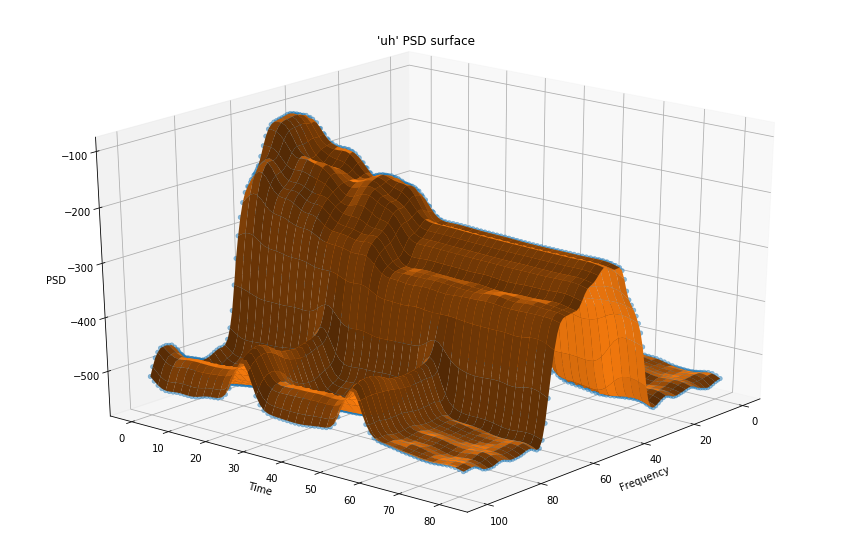

[(1, (6.13470470196672, 9.61282575236855)),
 (1, (6.872349197615162, 9.832519311058004)),
 (1, (4.381786194458367, 6.530518896640666)),
 (1, (2.229530141485017, 3.3945315001986214)),
 (1, (6.90593881559496, 7.7385799980115815)),
 (1, (2.7586645318243095, 3.4704204139876142)),
 (1, (3.495001446639728, 4.145442174638161)),
 (1, (2.4826335411358205, 3.0530091805428614)),
 (1, (1.7862124346882597, 2.2783457023858804)),
 (1, (1.8290940830505178, 2.2675357199125803)),
 (1, (1.8259790289520266, 2.236750722396236)),
 (1, (4.721653940700896, 5.123056229379621)),
 (1, (1.4167199648184159, 1.809915791449419)),
 (1, (2.1349837678400174, 2.3857274914411044)),
 (1, (2.9258642050140327, 3.1603975396926414)),
 (1, (1.7752708976162845, 2.0061195938972127)),
 (1, (6.408264015390665, 6.612242880987084)),
 (1, (1.344902637949361, 1.5487211967571122)),
 (1, (1.6172957911367607, 1.8210732284454387)),
 (1, (2.2439464325324057, 2.4268172145306846)),
 (1, (4.498809845621195, 4.645927358952105)),
 (1, (1.310477

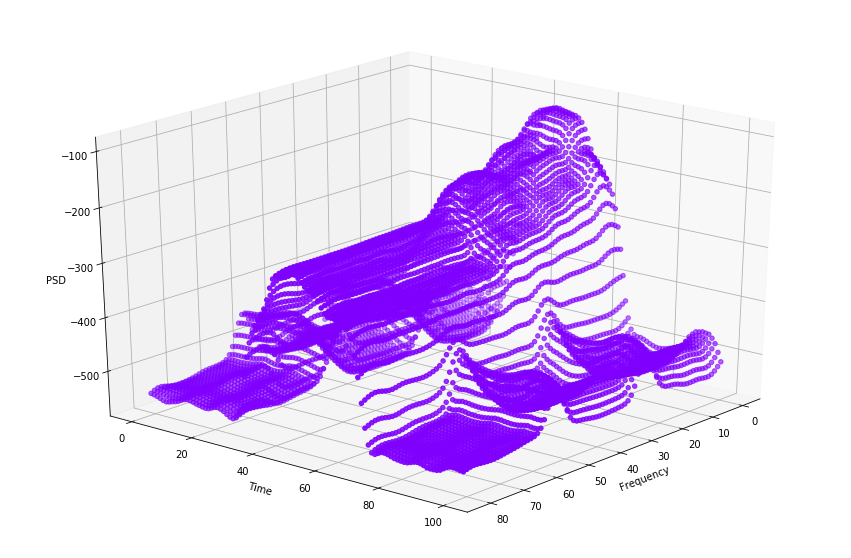

In [200]:
uh_data_s = wav_to_surface("uh", myPath)
plot_and_pers_diagram(uh_data_s, -160, True, True) 

(81, 100)


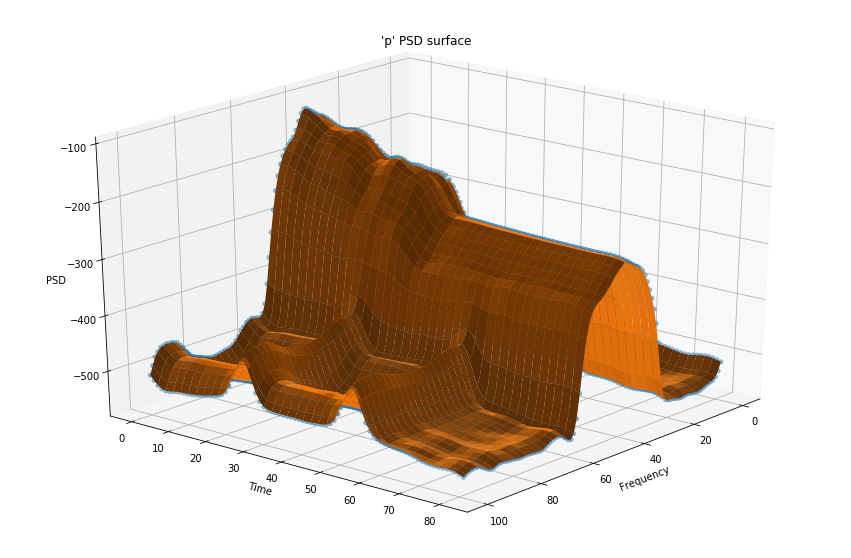

[(1, (2.935388421189169, 4.771381533704554)),
 (1, (2.2737099857716925, 3.717437111159959)),
 (1, (2.30590257012601, 3.5721865068284657)),
 (1, (3.088965857844776, 4.201266113083104)),
 (1, (3.243838022511274, 4.332192924338221)),
 (1, (2.2527239220741238, 3.06978426794117)),
 (1, (2.2911133763932057, 3.0731939686769456)),
 (1, (3.209931126875668, 3.988254217778867)),
 (1, (2.0107275793021744, 2.6221833752117427)),
 (1, (2.6046824146672076, 3.163141352863902)),
 (1, (2.776303688572942, 3.3260953326391784)),
 (1, (1.8663003553923563, 2.398106762748506)),
 (1, (3.9973895650137803, 4.466878990221736)),
 (1, (1.941112623070804, 2.3955346870829035)),
 (1, (1.9856264655286229, 2.426187249938599)),
 (1, (2.6852862769243515, 3.0689727650682563)),
 (1, (2.638496117786238, 3.0131327485013673)),
 (1, (3.014875365674597, 3.3715355477381026)),
 (1, (2.9543912284613194, 3.309436477537824)),
 (1, (1.132341643522591, 1.4143875129572308)),
 (1, (1.236847666091272, 1.513344975884841)),
 (1, (1.264618267

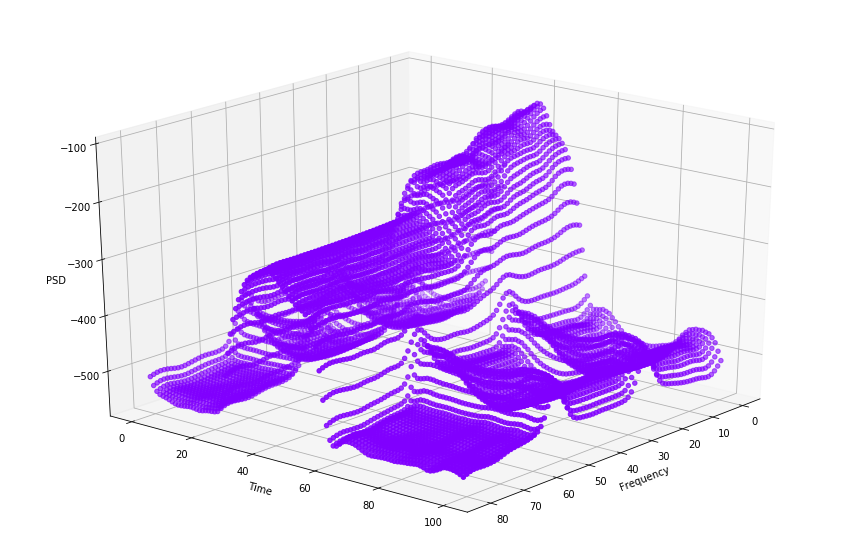

In [201]:
p_data_s = wav_to_surface("p", myPath)
plot_and_pers_diagram(p_data_s, -160, True, True) 

/Users/luketrujillo/Desktop/Senior_year/Spring/Seminar_in_Diff_Geo/143_final_project/code/wavs/up-us
(81, 100)


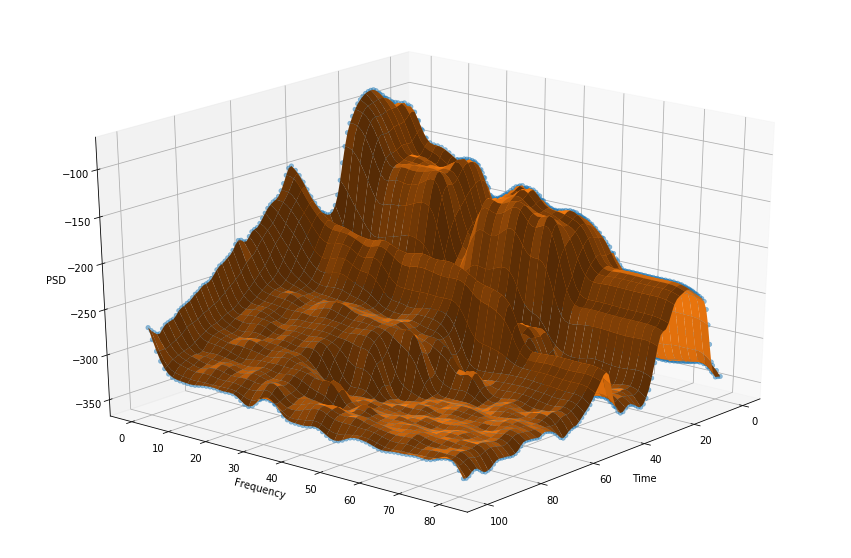

[(1, (3.445908621009401, 6.3238429818068065)),
 (1, (6.1293182934109725, 8.764924795945912)),
 (1, (3.5057169847782825, 6.083490147490729)),
 (1, (3.3713023652043157, 5.438554899079019)),
 (1, (4.55824262356034, 6.555216433135333)),
 (1, (2.7798922328199227, 4.774426654715064)),
 (1, (2.4933956258422088, 4.3107584484749815)),
 (1, (5.0811746421279524, 6.865310618894045)),
 (1, (2.3623892350073805, 3.94916125415798)),
 (1, (1.8693872501942987, 3.422696062817212)),
 (1, (3.113609911234672, 4.648031608075745)),
 (1, (5.242923817575597, 6.765912399403904)),
 (1, (4.60652451501845, 6.1108806952581265)),
 (1, (5.554333106351642, 7.039673711851722)),
 (1, (2.2588712349509694, 3.606338010437036)),
 (1, (3.0422697370236955, 4.300892631087124)),
 (1, (2.777675950270418, 4.005665220177374)),
 (1, (3.0827036061856297, 4.267322742144104)),
 (1, (4.748458368866572, 5.90723107503302)),
 (1, (5.704220926644908, 6.860743429155573)),
 (1, (1.6898200277373272, 2.722094928577725)),
 (1, (2.429922898840996

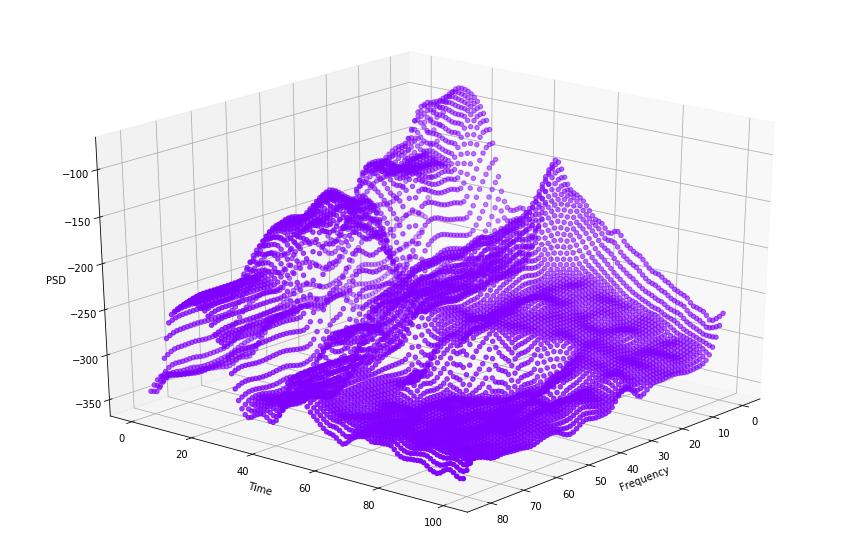

In [196]:
up_data_s = word_to_surface("up", myPath)
plot_and_pers_diagram(up_data_s, -160, True, True) 

In [162]:
result = np.where(zdata_s == np.amax(zdata_s))
result

(array([0]), array([16]))

In [189]:
def combine(word_data, phoneme_data_1, phoneme_data_2):
    word_max_index = np.where(word_data == np.amax(word_data))
    phoneme_1_max_index = np.where(phoneme_data_1 == np.amax(phoneme_data_1))
    phoneme_2_max_index = np.where(phoneme_data_2 == np.amax(phoneme_data_2))
    
    phon_1_scale = word_max_index[1][0]/phoneme_1_max_index[1][0]
    phon_2_scale = (100 - 100*phon_1_scale)/100
    
    Xs = np.linspace(0, 81, 81) #initialize our coordinates
    Ys = np.linspace(0, 100, 100)
    xdata = [Xs, Ys] #our x-y coordinates
    i,j = np.meshgrid(*xdata, indexing = "ij")  #creates the 28x28 grid
    k,l = np.meshgrid(*xdata, indexing = "ij")  #creates the 28x28 grid

    fig = plt.figure(figsize=(15, 10)) #creates a large plotting area
    ax = plt.axes(projection='3d')     #creates axes
    
    j = [x*phon_1_scale for x in j]
    ax.scatter(i, j, phoneme_data_1) #plots the surface
    
    l = [x*phon_2_scale + 100*phon_1_scale for x in l]
    ax.scatter(k, l, phoneme_data_2)
    
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Time ')
    ax.set_zlabel('PSD')
    ax.view_init(elev=25, azim=40)

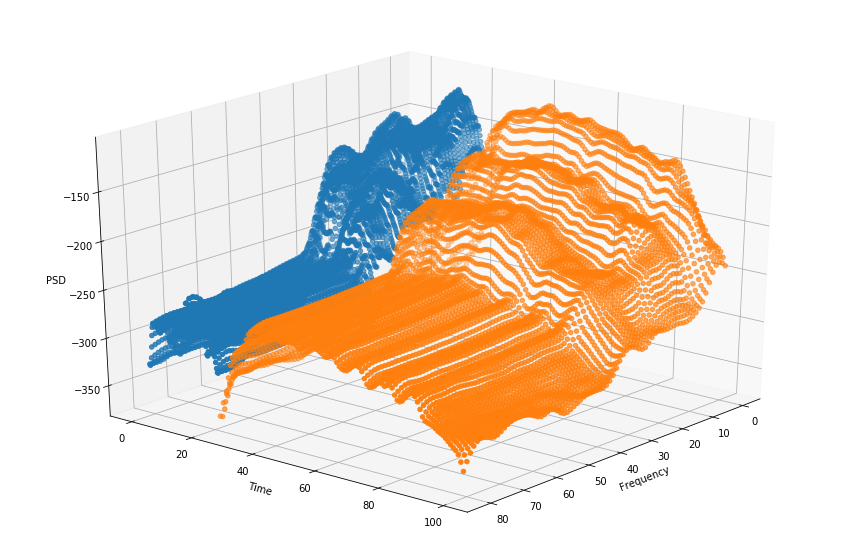

In [192]:
combine(car_data_s, k_data_s, ar_data_s)

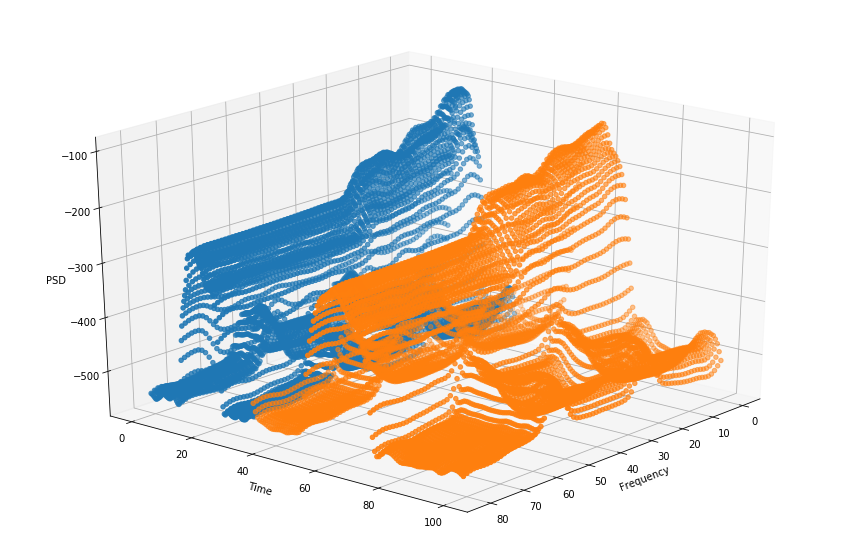

In [199]:
combine(up_data_s, uh_data_s, p_data_s)